In [366]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import itertools
import pandas as pd

## Load data to fit "ground truth" curves

In [4]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [5]:
def func(x, a, b):
    return np.exp(a)*x**b

In [6]:
params = []
true_cycle_lives = []
fit_cycle_lives = []
true_gammas = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    def parameter_estimation_function(x):
        return np.asarray(Y) - func(x=np.arange(1,len(Y)+1), a=x[0],b=x[1])- Y[0]
    
    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    params.append([alpha,beta])

    true_cycle_lives.append(bat["cycle_life"][0])
    fit_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-Y[0]),1/beta)])
    true_gammas.append([Y[0]])
params = np.array(params)
true_cycle_lives = np.array(true_cycle_lives)
fit_cycle_lives = np.array(fit_cycle_lives)
true_gammas = np.array(true_gammas)

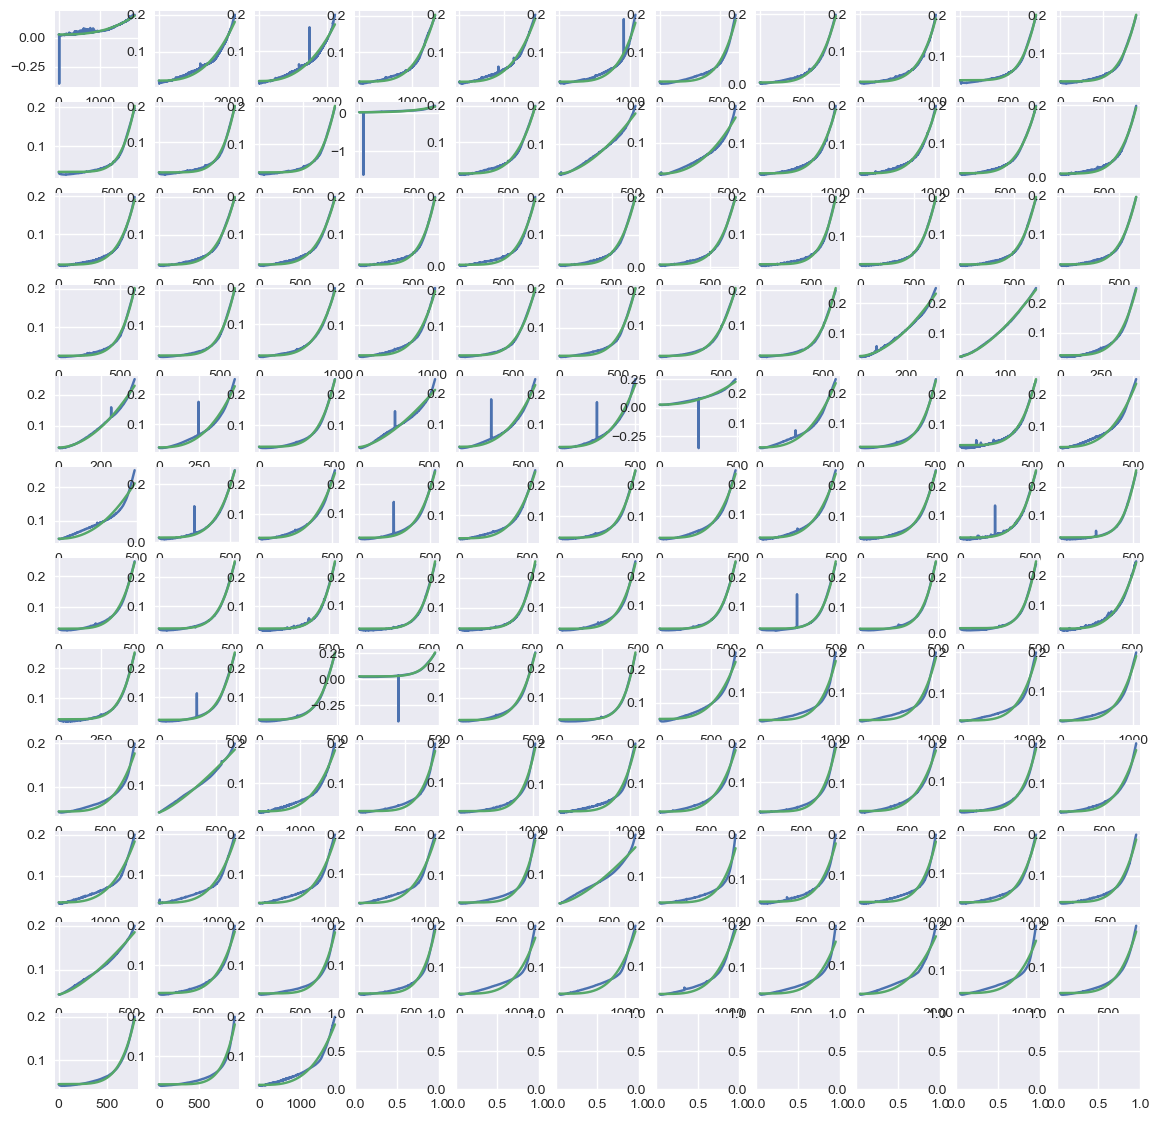

In [7]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    #gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta)+true_gammas[ix], linestyle="-")

## Pretty plots and curve fit analysis

In [372]:
rsqs = []
for ix,id in enumerate(bat_dict.keys()):
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1

    alpha = params[ix][0]
    beta = params[ix][1]
    Y_hat = func(x,alpha,beta)+true_gammas[ix]
    rsq = r2_score(Y,Y_hat)
    rsqs.append(rsq)
avg_rsq = np.mean(rsqs)
print("Average R-squared is:",avg_rsq)

Average R-squared is: 0.9763964167600441


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


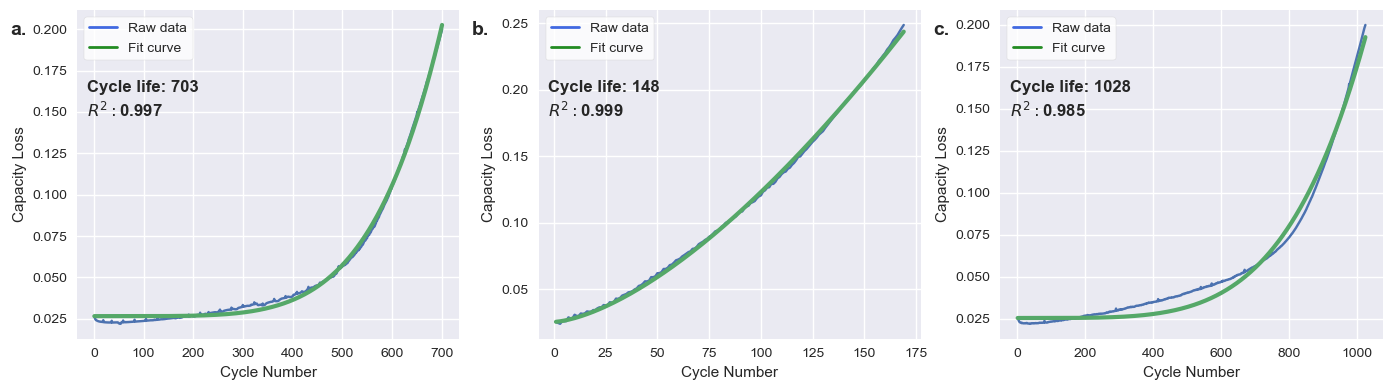

In [375]:
# partal visualization curve fits
fig,axs=plt.subplots(ncols=3,figsize=(14,4))
ids = ["b1c35","b2c1","b3c26"]
letters = ["a","b","c"]
for ix,id in enumerate(ids):
    ax = axs[ix]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    Y_hat = func(x,alpha,beta)+Y[0]
    ax.plot(x, func(x,alpha,beta)+Y[0], linewidth=3)

    ax.set_xlabel("Cycle Number")
    ax.set_ylabel("Capacity Loss")
    ax.legend()

    legend_elements = [Line2D([0], [0], color='royalblue', lw=2, label="Raw data"),
                   Line2D([0], [0], color='forestgreen', lw=2, label="Fit curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")

    ax.text(0.025,0.75,"Cycle life: "+str(int(bat_dict[id]["cycle_life"][0,0])),fontsize=12, fontweight="semibold",transform=ax.transAxes)

    rsq = r2_score(Y,Y_hat)
    ax.text(0.025,0.675,"$R^2:$"+str(round(rsq,3)),fontsize=12, fontweight="semibold",transform=ax.transAxes)
    ax.text(-0.175,0.925,letters[ix]+".",fontsize=14,fontweight="semibold",transform=ax.transAxes)

fig.tight_layout()
plt.savefig("../images/curve_fits_lsq.png",dpi=300)

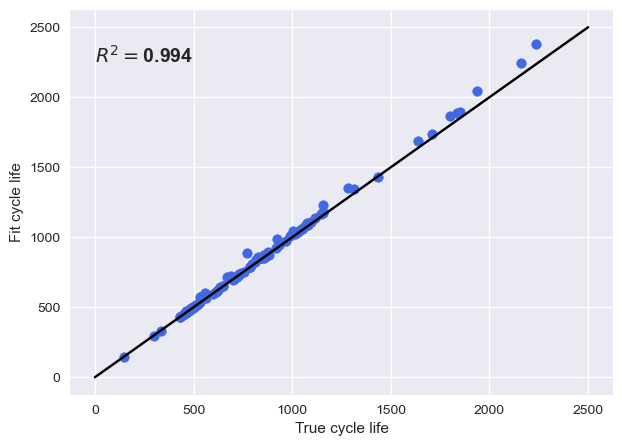

In [376]:
# visualize cycle life from fit curves vs. true cycle lives
fig,ax=plt.subplots(figsize=(7,5))
ax.scatter(true_cycle_lives,fit_cycle_lives,color="royalblue")
ax.plot(np.linspace(0,2500),np.linspace(0,2500),color="black")
ax.set_xlabel("True cycle life")
ax.set_ylabel("Fit cycle life")
r_sq = r2_score(true_cycle_lives[:,0],fit_cycle_lives[:,0])
ax.text(0,2250,"$R^2=$"+str(round(r_sq,3)),fontsize=14,fontweight="semibold")
plt.savefig("fitvtrue_cyclelives.png",dpi=300)

## Functions for training

In [8]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [46]:
def prep_data(settings, params, true_cycle_lives, fit_cycle_lives,scale_input=False,scale_output=False):
    data = np.loadtxt(settings["input_file"],delimiter=',',skiprows=1) # skip row for column names

    x_train = data[:,settings["input_indices"]][train_ind]
    y_train = params[train_ind]
    true_life_train = true_cycle_lives[train_ind]
    fit_life_train = fit_cycle_lives[train_ind]
    true_gammas_train = true_gammas[train_ind]

    x_test = data[:,settings["input_indices"]][test_ind]
    y_test = params[test_ind]
    true_life_test = true_cycle_lives[test_ind]
    fit_life_test = fit_cycle_lives[test_ind]
    true_gammas_test = true_gammas[test_ind]

    x_stest = data[:,settings["input_indices"]][secondary_ind]
    y_stest = params[secondary_ind]
    true_life_stest = true_cycle_lives[secondary_ind]
    fit_life_stest = fit_cycle_lives[secondary_ind]
    true_gammas_stest = true_gammas[secondary_ind]

    if scale_input:
        in_scaler = preprocessing.StandardScaler().fit(list(x_train))
        x_train = in_scaler.transform(list(x_train))
        x_test = in_scaler.transform(list(x_test))
        x_stest = in_scaler.transform(list(x_stest))

    if scale_output:
        mean = np.mean(y_train,axis=0)
        sd = np.std(y_train,axis=0)
        y_train = (y_train-mean)/sd
        y_test = (y_test-mean)/sd
        y_stest = (y_stest-mean)/sd

    train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(true_life_train),torch.Tensor(fit_life_train),torch.Tensor(true_gammas_train))
    test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(true_life_test),torch.Tensor(fit_life_test),torch.Tensor(true_gammas_test))
    stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(true_life_stest),torch.Tensor(fit_life_stest),torch.Tensor(true_gammas_stest))
    
    if scale_output: return train,test,stest,mean,sd
    else: return train,test,stest

In [11]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_sizeS, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [12]:
class weighted_MSELoss(nn.Module):
    '''calculates MSE of scaled/normalized parameters'''
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

In [48]:
def predict_error(settings,model,train,test,stest):
    errors = []
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    for i,dataset in enumerate([train,test,stest]):
        predicted =[]
        labels = []
        for cell in dataset:
            input, _, true_life, _, true_gamma = cell
            pred = model(input[None,:].to(device)).detach().numpy()[0]
            if settings["scale_output"]: 
                pred = pred*settings["output_sd"]+settings["output_mean"]
            pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma[0]),1/pred[1])

            predicted.append(pred_life)
            labels.append(true_life[0])

        errors.append(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    return errors

In [150]:
def make_plots(settings,model,train,test,stest,savefig=False):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    np.set_printoptions(suppress=True)

    fig, ax = plt.subplots(figsize=(7,5))
    if settings["illustrative"]: fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

    colors = ["blue","red","orange"]
    markers = ["o","v","s"]
    sizes = [5,6,5]
    parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
    ix = 0

    for i,dataset in enumerate([train,test,stest]):
        predicted =[]
        labels = []
        for cell in dataset:
            input, label, true_life, _, true_gamma = cell
            pred = model(input[None,:].to(device)).detach().numpy()[0]
            if settings["scale_output"]: 
                pred = pred*settings["output_sd"]+settings["output_mean"]
                label = label*settings["output_sd"]+settings["output_mean"]
            pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma[0]),1/pred[1])

            parameter_results[i][0].append(label.detach().numpy())
            parameter_results[i][1].append(pred)
            predicted.append(pred_life)
            labels.append(true_life[0])

            n = 100
            x = torch.Tensor(np.arange(1,n))
            fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
            pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma

            # plot predicted vs. ground truth curves
            if settings["illustrative"]: 
                ax_curve = axs_curve[int(ix/11)][ix%11]
                ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
                ax_curve.plot(pred_curve, color="lightcoral")
                ix+=1

        print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
        ax.plot(labels, predicted, markers[i],color=colors[i],markersize=sizes[i])
        ax.set_xlabel("Truth")
        ax.set_ylabel("Predicted")

    # plot predicted vs. actual cycle lives
    ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
    ax.set_ylim([0,2500])
    #ax.set_title("Battery Life Predictions",fontweight="semibold")

    legend_elements = [Line2D([0], [0], marker='o', color="w", label='Train',
                          markerfacecolor='blue', markersize=12),
                          Line2D([0], [0], marker='v', color="w", label='Test',
                          markerfacecolor='red', markersize=12),
                          Line2D([0], [0], marker='s', color="w", label='Secondary test',
                          markerfacecolor='orange', markersize=12)]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")
    plt.show()
    if savefig: fig.savefig("../images/selfattn_stage2_cyclelives.png",dpi=300)

    if settings["illustrative"]: 
        # plot predicted vs. ground truth model parameters
        for i in range(3):
            parameter_results[i][0] = np.array(parameter_results[i][0])
            parameter_results[i][1] = np.array(parameter_results[i][1])

        plt.rcParams["figure.figsize"] = (12, 5)
        fig, axs = plt.subplots(1, 2)
        for i, title in zip(range(2), ["a", "b"]):
            axs[i].set_title(title)
            for j, lab in zip(range(3), ["train", "test", "secondary"]):
                axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
                axs[i].set_xlabel("True")
                axs[i].set_ylabel("Predicted")
            axs[i].legend()
        plt.show()

## Run model with chosen settings

In [90]:
settings = {"input_file": "./../Data/features5.csv", # name of file with input data
            "input_indices": [1,2,3,14,15], # column indices of features to feed in
            "scale_input": False, "scale_output": False,
            "d_model": 2, "vdim": 2, "feat_dim": 1, "skip_connect": 0, "batch_size": 1, "attn_model": "softmax", # self-attention parameters
            "nepoch_coarse": 800, "nepoch_fine": 3000, # number of epochs for first and second training stages
            "lr_coarse": 1e-3, "lr_fine": 5e-5, # learning rate for first and second training stages
            "curve_loss": False, "n_points": 100, "curve_weight": 0.01, # do we include diff bw curves in loss function?
            'weighted_points': True,
            "param_weights": torch.Tensor([1/32, 1]), # do we vary how much to weight each parameter in loss? can use to normalize param magnitudes
            "verbose": True, "illustrative":True} 

In [69]:
if settings["scale_output"]: 
    train,test,stest,mean,sd = prep_data(settings,params,true_cycle_lives,fit_cycle_lives,settings["scale_input"],settings["scale_output"])
    settings["output_mean"] = mean
    settings["output_sd"] = sd
else: 
    train,test,stest = prep_data(settings,params,true_cycle_lives,fit_cycle_lives,settings["scale_input"],settings["scale_output"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [70]:
def ensemble_train(settings,ensemble_size=5):
    avg_pred_error = []
    for i in range(ensemble_size):
        model = AttentionModel(d_model=settings["d_model"],feat_dim=settings["feat_dim"],n_cycle=len(settings["input_indices"]),
                            vdim=settings["vdim"],attn_model=settings["attn_model"],skip_connect=settings["skip_connect"])
        criterion = weighted_MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=settings["lr_coarse"])

        model.train()
        # Training loop
        for i in range(settings["nepoch_coarse"]):
            total_loss_train = 0.0
            total_loss_test = 0.0
            total_loss_stest = 0.0

            train_batched = DataLoader(train,batch_size=settings["batch_size"],shuffle=True)
            test_batched = DataLoader(test,batch_size=1)
            stest_batched = DataLoader(stest,batch_size=1)

            for j,batch in enumerate(train_batched):
                optimizer.zero_grad()
                train_input, train_label, true_life, fit_life, true_gamma = batch
                output = model(train_input.to(device))
                
                loss = criterion(output,train_label,settings["param_weights"])

                if settings["curve_loss"]:
                    n = settings["n_points"] # number of points at which to calculate curve loss
                    x = torch.Tensor(np.arange(1,n+1))
                    if settings["scale_output"]: 
                        output = output*settings["output_sd"]+settings["output_mean"]
                        train_label = train_label*settings["output_sd"]+settings["output_mean"]
                    
                    fit_curve = torch.exp(train_label[:,0])*torch.pow(x*(true_life/n),train_label[:,1])+true_gamma
                    pred_curve = torch.exp(output[:,0])*torch.pow(x*(true_life/n),output[:,1])+true_gamma
                    # calc loss as a linear combination of difference between curves and MSE loss of parameters
                    if settings["weighted_points"]: point_weights = torch.Tensor(np.linspace(1,2,n))
                    else: point_weights = torch.Tensor(np.ones(n))
                    loss += settings["curve_weight"]*criterion(fit_curve,pred_curve,point_weights)

                total_loss_train += loss.item()

                loss.backward()
                optimizer.step()

            rmse_train = np.sqrt(total_loss_train / (j+1))
            if (i+1)%100 == 0 and settings["verbose"]: 
                print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f}')

        if settings["illustrative"]: make_plots(settings,model,train,test,stest)

        pred_error = predict_error(settings,model,train,test,stest)
        avg_pred_error.append(pred_error)
    avg_pred_error = np.mean(avg_pred_error,axis=0)
    return avg_pred_error, model

Epochs: 100 | rmse:  1.780
Epochs: 200 | rmse:  1.195
Epochs: 300 | rmse:  1.174
Epochs: 400 | rmse:  1.172
Epochs: 500 | rmse:  1.171
Epochs: 600 | rmse:  1.171
Epochs: 700 | rmse:  1.172
Epochs: 800 | rmse:  1.170
281.3801812409585
346.6827868493677
416.51741008887177


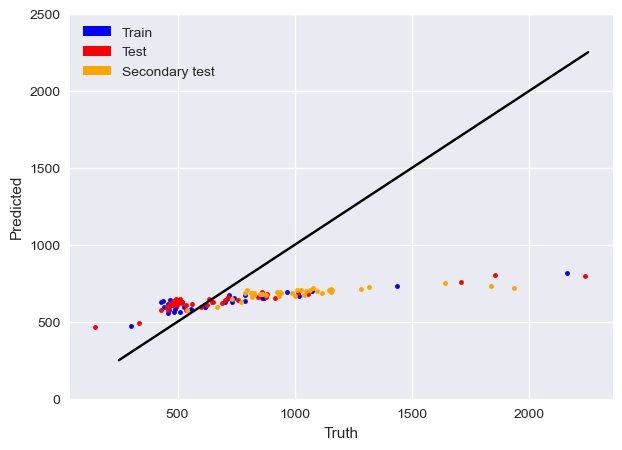

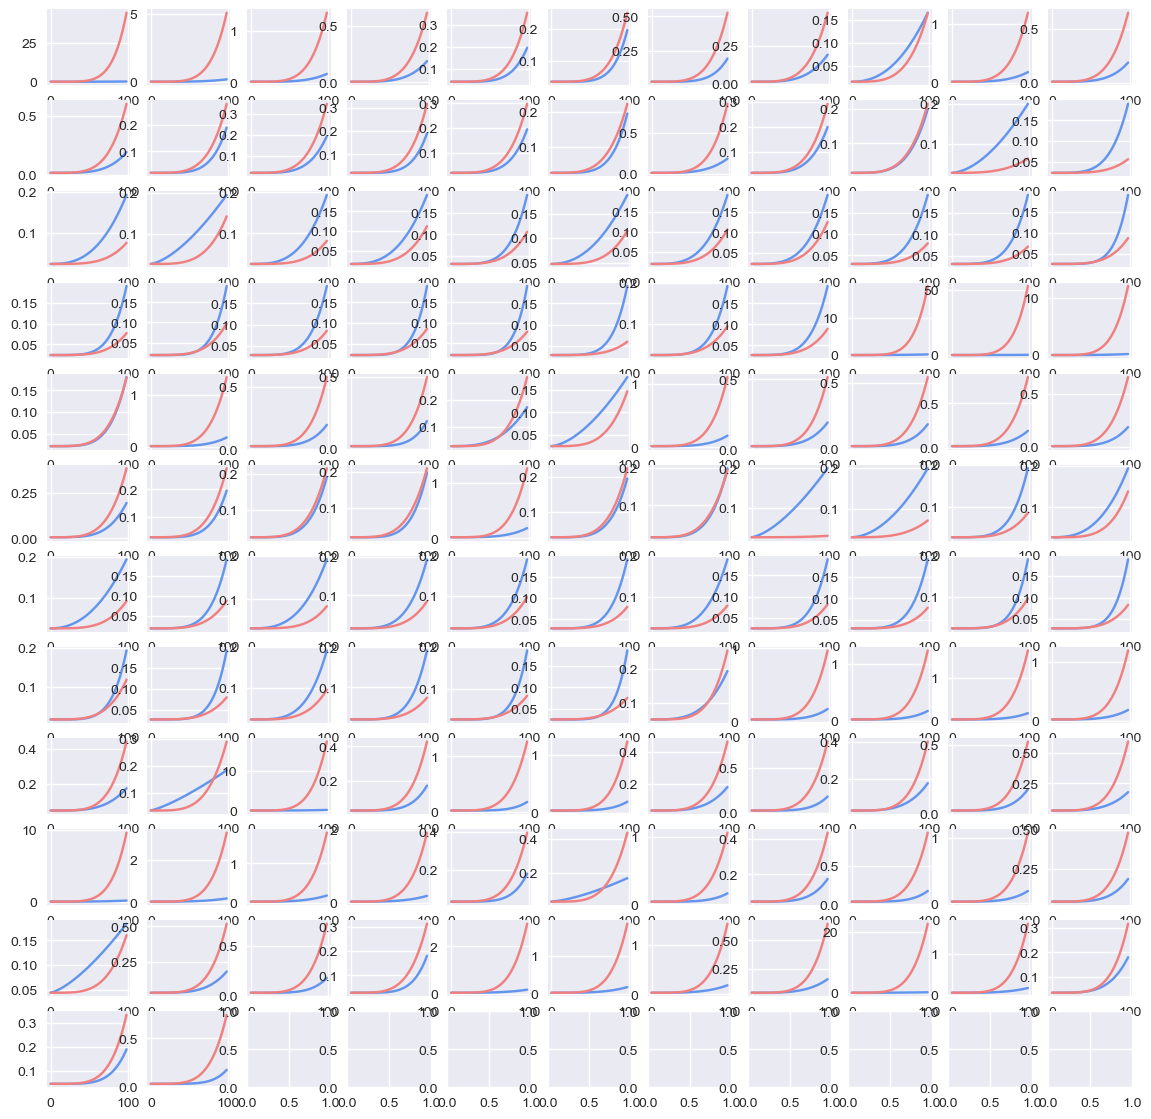

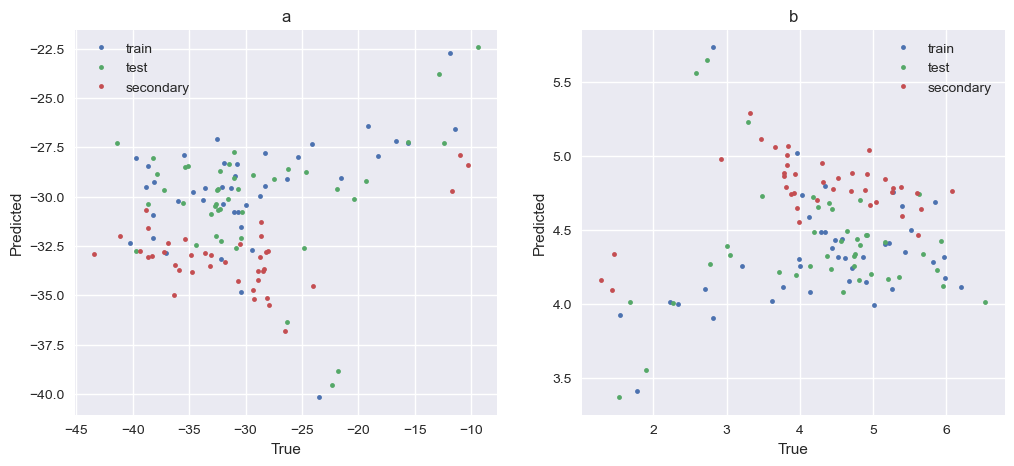

In [82]:
_, model = ensemble_train(settings,ensemble_size=1)

## Second round of training (calc loss w/ cycle lifetime)

In [91]:
# create a deep copy of model to fine tune
model2 = copy.deepcopy(model)

In [92]:
# low learning rate and many epochs for fine-tuning
optimizer_fine = torch.optim.Adam(model2.parameters(), lr=settings["lr_fine"])
#criterion = nn.MSELoss().to(device)
criterion = weighted_MSELoss().to(device)
n_fine = 100 # number of points at which to compare predicted curve with fitted curve
x_fine = torch.Tensor(np.arange(1,n_fine+1))
life_weight = 1

In [96]:
model2.train()

# Training loop
for i in range(1000):#settings["nepoch_fine"]):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=settings["batch_size"],shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life, fit_life, true_gamma = batch
        output = model2(train_input.to(device))

        if settings["scale_output"]: 
            output = output*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])
            train_label = train_label*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-true_gamma),1/output[:,1])
        fit_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-true_gamma),1/train_label[:,1])
        #if torch.isnan(pred_life): 
        #    print(output)
        #    break

        fit_curve = torch.exp(train_label[:,0])*torch.pow(x_fine*(true_life/n_fine),train_label[:,1])+true_gamma
        pred_curve = torch.exp(output[:,0])*torch.pow(x_fine*(true_life/n_fine),output[:,1])+true_gamma
        #loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))
        #loss = criterion(output, train_label)
        loss = criterion(pred_life,fit_life,torch.Tensor([1]))
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life, fit_life, true_gamma = cell
        test_output = model2(test_input.to(device))
        if settings["scale_output"]: 
            test_output = test_output*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])
            test_label = test_label*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-true_gamma),1/test_output[:,1])
        fit_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-true_gamma),1/test_label[:,1])

        fit_curve = torch.exp(test_label[:,0])*torch.pow(x_fine*(true_life/n_fine),test_label[:,1])+true_gamma
        pred_curve = torch.exp(test_output[:,0])*torch.pow(x_fine*(true_life/n_fine),test_output[:,1])+true_gamma
        #test_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))
        test_loss = criterion(pred_life,true_life,torch.Tensor([1]))

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life, fit_life, true_gamma = cell
        stest_output = model2(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)
        if settings["scale_output"]: 
            stest_output = stest_output*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])
            stest_label = stest_label*torch.Tensor(settings["output_sd"])+torch.Tensor(settings["output_mean"])

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-true_gamma),1/stest_output[:,1])
        fit_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-true_gamma),1/stest_label[:,1])

        fit_curve = torch.exp(stest_label[:,0])*torch.pow(x_fine*(true_life/n_fine),stest_label[:,1])+true_gamma
        pred_curve = torch.exp(stest_output[:,0])*torch.pow(x_fine*(true_life/n_fine),stest_output[:,1])+true_gamma
        #stest_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))
        stest_loss = criterion(pred_life,true_life,torch.Tensor([1]))
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')
        #print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f}')

Epochs: 100 | rmse:  116.116 | rmse_test:  129.379 | rmse_stest:  181.516
Epochs: 200 | rmse:  115.393 | rmse_test:  128.722 | rmse_stest:  180.974
Epochs: 300 | rmse:  114.921 | rmse_test:  128.320 | rmse_stest:  180.698
Epochs: 400 | rmse:  114.939 | rmse_test:  128.103 | rmse_stest:  180.010
Epochs: 500 | rmse:  114.449 | rmse_test:  127.947 | rmse_stest:  180.425
Epochs: 600 | rmse:  114.635 | rmse_test:  127.876 | rmse_stest:  180.446
Epochs: 700 | rmse:  114.280 | rmse_test:  127.837 | rmse_stest:  180.244
Epochs: 800 | rmse:  114.376 | rmse_test:  127.823 | rmse_stest:  180.226
Epochs: 900 | rmse:  114.233 | rmse_test:  127.826 | rmse_stest:  179.926
Epochs: 1000 | rmse:  114.244 | rmse_test:  127.832 | rmse_stest:  179.916


113.0255447451513
127.8315311875032
179.91565341123928


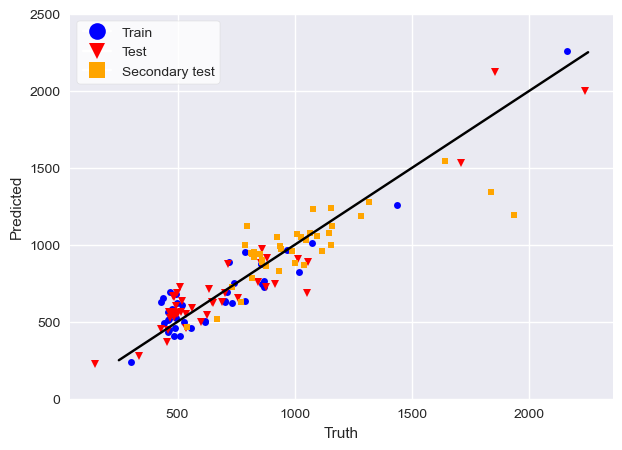

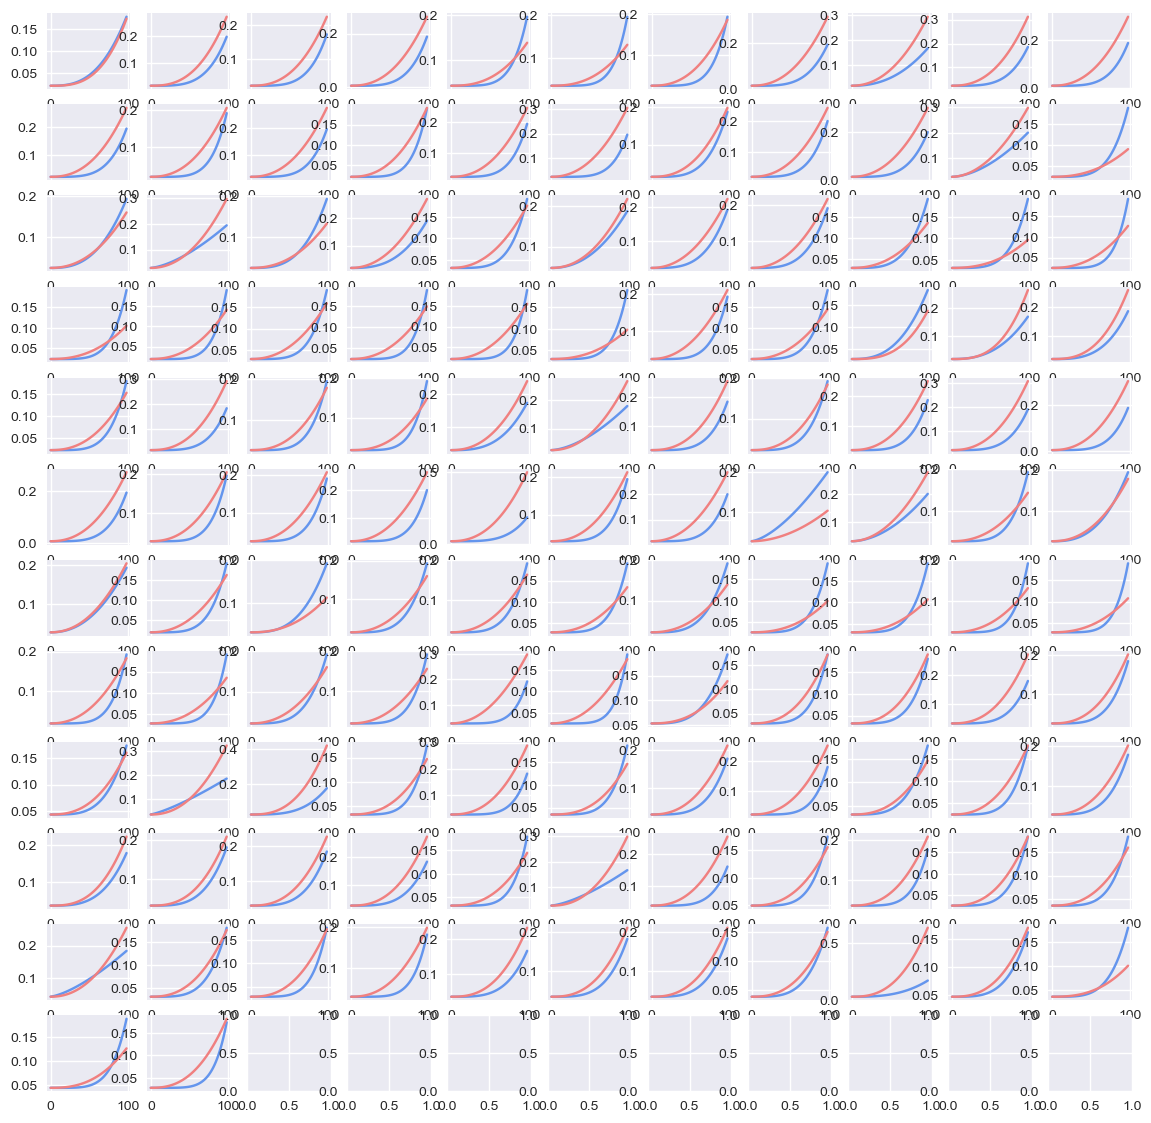

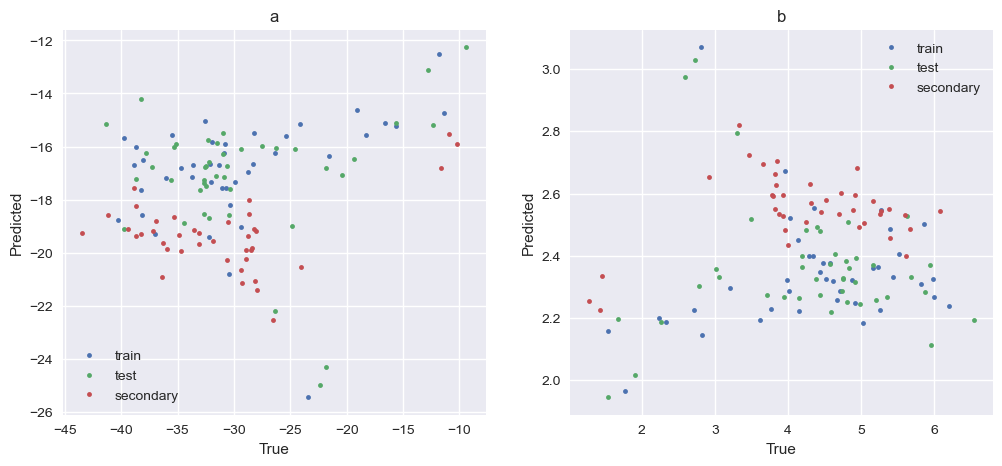

In [151]:
make_plots(settings,model2,train,test,stest,savefig=True)

In [355]:
params_pred = []
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
for i,dataset in enumerate([train,test,stest]):
    for cell in dataset:
        input, label, true_life, _, true_gamma = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        params_pred.append(list(pred))
params_pred = np.array(params_pred)

In [248]:
import sklearn
lregr = sklearn.linear_model.LinearRegression().fit(params[:,0].reshape(-1, 1),params[:,1])

In [250]:
print(lregr.coef_,lregr.intercept_)

[-0.15080426] -0.24284793655222803


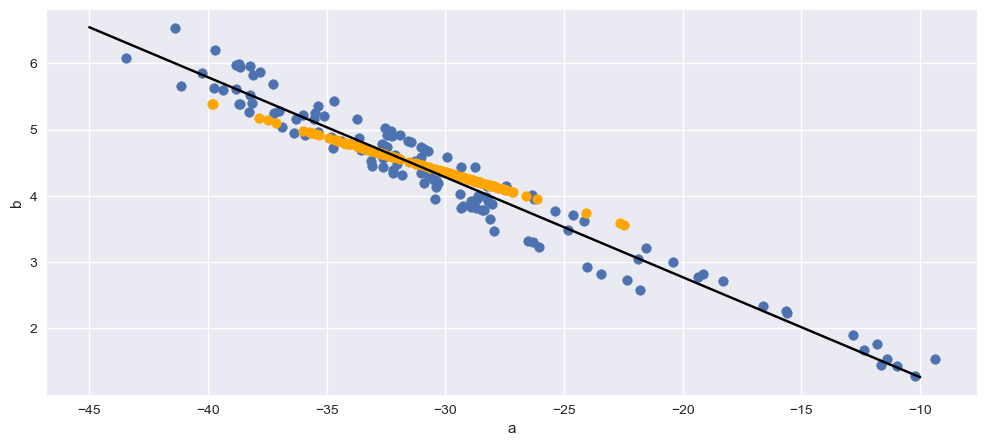

In [356]:
fig,ax=plt.subplots()
ax.scatter(params[:,0],params[:,1])
ax.set_xlabel("a")
ax.set_ylabel("b")
x = np.linspace(-45,-10)
ax.plot(x,lregr.coef_[0]*x+lregr.intercept_,color="black")

ax.scatter(params_pred[:,0],params_pred[:,1],c="orange")

# Playing with visualization of parameter loss

In [131]:
i = 0
for cell in train:
    if i==18:
        input, label, true_life, _, true_gamma = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]

        n = 100
        x = torch.Tensor(np.arange(1,n))
        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma
        break
    i+=1

In [132]:
print(pred,label)
print(pred-label.detach().numpy())
print(np.mean(np.power(pred-label.detach().numpy(),2)*(1/32,1)))

[-29.545431   4.317238] tensor([-31.2991,   4.5225])
[ 1.7536526  -0.20521832]
0.06910879909992218


In [133]:
diff = label.detach().numpy()-pred
pred2 = [pred[0], pred[1] + 2*diff[1]]
print(pred2,label)
print(pred2-label.detach().numpy())
print(np.mean(np.power(pred2-label.detach().numpy(),2)*(1/32,1)))
pred_curve2 = np.exp(pred2[0])*np.power(x*(true_life/n),pred2[1])+true_gamma

[-29.545431, 4.72767448425293] tensor([-31.2991,   4.5225])
[1.75365257 0.20521832]
0.06910879945468196


In [134]:
pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma),1/pred[1])
pred_life2 = np.power(np.exp(-pred2[0])*(0.2-true_gamma),1/pred2[1])
print(true_life,pred_life,pred_life2)

tensor([702.]) tensor([631.8032]) tensor([360.9501])


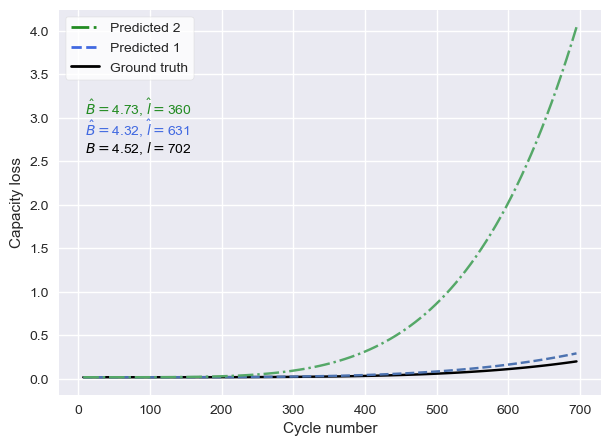

In [147]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(x*(true_life/n),fit_curve,color="black")
ax.plot(x*(true_life/n),pred_curve,linestyle="dashed")
ax.plot(x*(true_life/n),pred_curve2,linestyle="dashdot")
ax.set_xlabel("Cycle number")
ax.set_ylabel("Capacity loss")

legend_elements = [Line2D([0], [0], color='forestgreen', lw=2, linestyle="dashdot", label="Predicted 2"),
                   Line2D([0], [0], color='royalblue', lw=2, linestyle="dashed", label="Predicted 1"),
                   Line2D([0], [0], color='black', lw=2, label="Ground truth")]
ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")

ax.text(10,3.05,"$\hat{B}=$"+str(round(pred2[1],2))+", $\hat{l}=$"+str(int(pred_life2)),color="forestgreen")
ax.text(10,2.8,"$\hat{B}=$"+str(round(pred[1],2))+", $\hat{l}=$"+str(int(pred_life)),color="royalblue")
ax.text(10,2.6,"$B=$"+str(round(label.detach().numpy()[1],2))+", $l=$"+str(int(true_life)),color="black")
plt.savefig("parametereffect.png",dpi=300)

## Predicted curve fits

In [307]:
data = np.loadtxt(settings["input_file"],delimiter=',',skiprows=1) # skip row for column names

x_all = data[:,settings["input_indices"]]
y_all = params
true_life_all = true_cycle_lives
fit_life_all = fit_cycle_lives
true_gammas_all = true_gammas

In [384]:
rsqs = []
for idx in range(124):
    cell =(torch.Tensor(x_all[idx]),torch.Tensor(y_all[idx]),torch.Tensor(true_life_all[idx]),
        torch.Tensor(fit_life_all[idx]),torch.Tensor(true_gammas_all[idx]))
    input, label, true_life, _, true_gamma = cell
    pred = model2(input[None,:].to(device)).detach().numpy()[0]

    if settings["scale_output"]: 
        pred = pred*settings["output_sd"]+settings["output_mean"]
        label = label*settings["output_sd"]+settings["output_mean"]

    n = 100
    x = torch.Tensor(np.arange(1,n))
    fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
    pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma
    #rsq = np.corrcoef(fit_curve.numpy(),pred_curve.numpy())[0,1]**0.5
    #rsq = 1-np.sum(np.power((fit_curve.numpy()-pred_curve.numpy()),2))/np.sum(np.power(fit_curve.numpy()-np.mean(fit_curve.numpy()),2))
    rsq = r2_score(fit_curve.numpy(),pred_curve.numpy())
    rsqs.append(rsq)
avg_rsq = np.mean(rsqs)
print(avg_rsq)

0.01187863251883999


In [388]:
for i,rsq in enumerate(rsqs):
    print(i,rsq)

0 0.7927014065533696
1 0.9903028033474063
2 0.4297930258520958
3 0.24550361874486004
4 0.4819441604694623
5 0.1715156174681265
6 0.8377884606415948
7 -0.11727943772238847
8 -1.0202077600406523
9 0.8487953885447362
10 0.8122958434297513
11 0.8140138627147362
12 0.8253284716498501
13 0.647062797605398
14 0.26891879149092546
15 -1.064414387178783
16 0.5277373587515728
17 -0.6240923976498232
18 -0.13598345016197544
19 -1.4393241792576421
20 0.8501307009390359
21 -1.0565522265922773
22 -0.19092126258825703
23 -0.22170526028221693
24 -1.1659757971226994
25 0.38389787112817886
26 -1.2072888281160368
27 -0.5182528583766712
28 -0.2778608470737729
29 0.49523361655758724
30 0.4801662839591184
31 -0.12060938452341019
32 0.460334278494131
33 -1.987560044926803
34 -0.5300016640442
35 0.7894737930625535
36 -10.170550781982497
37 0.21028626166852327
38 0.43746356322245594
39 -0.7471043111682663
40 -0.7218449948277326
41 0.3764687261687658
42 0.012690409602186148
43 0.5995182227580916
44 0.576153054749

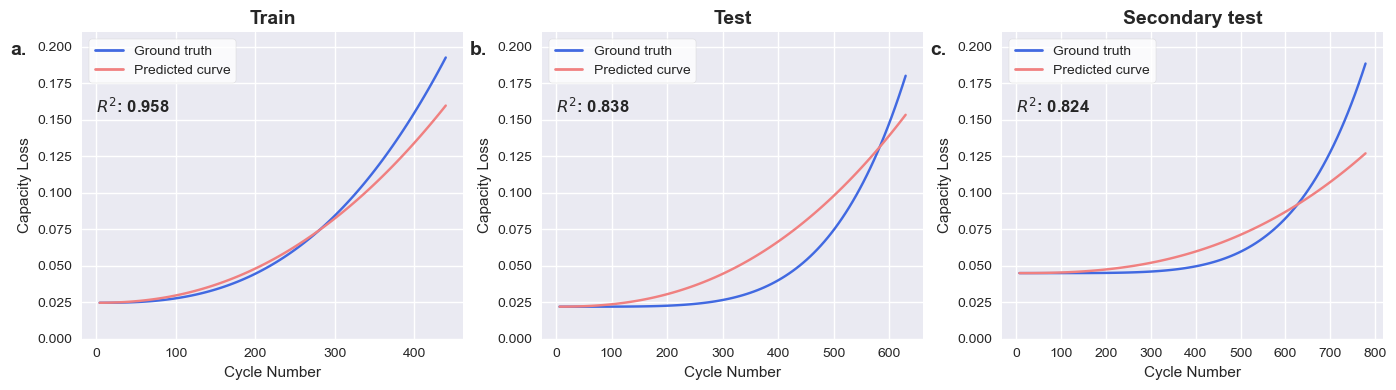

In [408]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,4))
letters = ["a","b","c"]
titles = ["Train","Test","Secondary test"]
for i,idx in enumerate([45,6,121]):
    ax = axs[i]
    cell =(torch.Tensor(x_all[idx]),torch.Tensor(y_all[idx]),torch.Tensor(true_life_all[idx]),
        torch.Tensor(fit_life_all[idx]),torch.Tensor(true_gammas_all[idx]))
    input, label, true_life, _, true_gamma = cell
    pred = model2(input[None,:].to(device)).detach().numpy()[0]
    pred_life = np.power(np.exp(-pred2[0])*(0.2-true_gamma),1/pred2[1])

    if settings["scale_output"]: 
        pred = pred*settings["output_sd"]+settings["output_mean"]
        label = label*settings["output_sd"]+settings["output_mean"]

    n = 100
    x = torch.Tensor(np.arange(1,n))
    fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
    pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma

    ax.plot(x*(true_life/n),fit_curve,color="royalblue")
    ax.plot(x*(true_life/n),pred_curve,color="lightcoral")

    ax.set_xlabel("Cycle Number")
    ax.set_ylabel("Capacity Loss")

    legend_elements = [Line2D([0], [0], color='royalblue', lw=2, label="Ground truth"),
                   Line2D([0], [0], color='lightcoral', lw=2, label="Predicted curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")

    rsq = r2_score(fit_curve.numpy(),pred_curve)
    ax.text(0,0.155,"$R^2$: "+str(round(rsq,3)),fontsize=12, fontweight="semibold")
    ax.set_ylim(0,0.21)
    ax.text(-0.19,0.925,letters[i]+".",fontsize=14,fontweight="semibold",transform=ax.transAxes)
    ax.set_title(titles[i],fontsize=14,fontweight="semibold")
fig.tight_layout()
plt.savefig("../images/predcurves_rsq.png")


## Patent fig

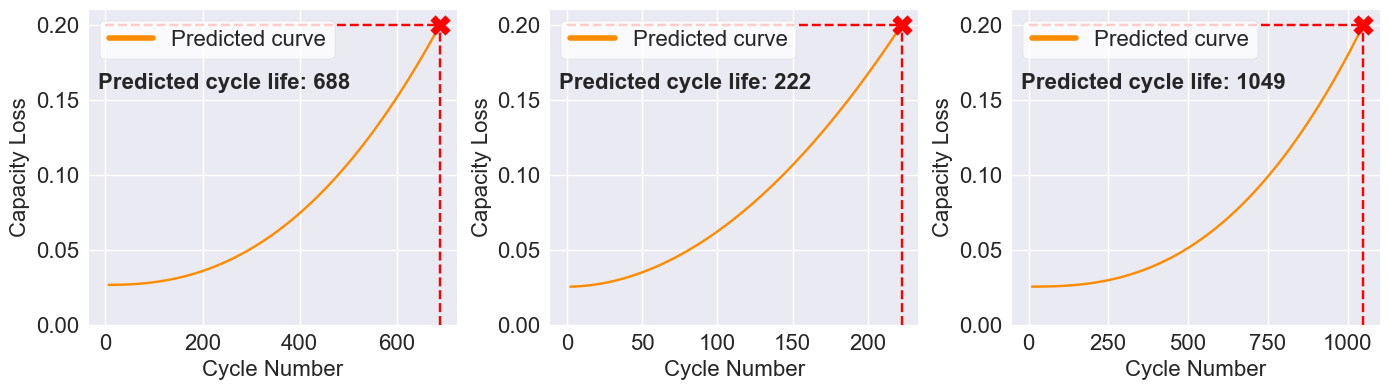

In [321]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,4))
for i,idx in enumerate([30,42,108]):
    ax = axs[i]
    cell =(torch.Tensor(x_all[idx]),torch.Tensor(y_all[idx]),torch.Tensor(true_life_all[idx]),
        torch.Tensor(fit_life_all[idx]),torch.Tensor(true_gammas_all[idx]))
    input, label, true_life, _, true_gamma = cell
    pred = model(input[None,:].to(device)).detach().numpy()[0]
    pred2 = model2(input[None,:].to(device)).detach().numpy()[0]
    pred2_life = np.power(np.exp(-pred2[0])*(0.2-true_gamma),1/pred2[1])

    if settings["scale_output"]: 
        pred = pred*settings["output_sd"]+settings["output_mean"]
        label = label*settings["output_sd"]+settings["output_mean"]

    n = 100
    x = torch.Tensor(np.arange(1,n))
    fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
    pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma
    #pred_curve2 = np.exp(pred2[0])*np.power(x*(true_life/n),pred2[1])+true_gamma
    pred_curve2 = np.exp(pred2[0])*np.power(x*(pred2_life/n),pred2[1])+true_gamma

    #ax.plot(x*(true_life/n),fit_curve,color="black")
    #ax.plot(x*(true_life/n),pred_curve,color="blue")
    ax.plot(x*(pred2_life/n),pred_curve2,color="darkorange")

    ax.hlines(0.2,0,pred2_life,color="red",linestyle="dashed")
    ax.vlines(pred2_life,0,0.2,color="red",linestyle="dashed")
    ax.scatter(pred2_life,0.2,marker="X",s=200,c="red",zorder=200)
    ax.set_ylim(0,0.21)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    legend_elements = [Line2D([0], [0], color='darkorange', lw=4, label="Predicted curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white",fontsize=16)

    ax.text(0.025,0.75,"Predicted cycle life: "+str(int(pred2_life)),fontsize=16, fontweight="semibold",transform=ax.transAxes)

    ax.set_xlabel("Cycle Number",fontsize=16)
    ax.set_ylabel("Capacity Loss",fontsize=16)
fig.tight_layout()
plt.savefig("../images/predicted_curves.png",dpi=300)

In [305]:
np.argmax(np.array(list(bat_dict.keys()))=="b3c26")

108

## Another patent fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


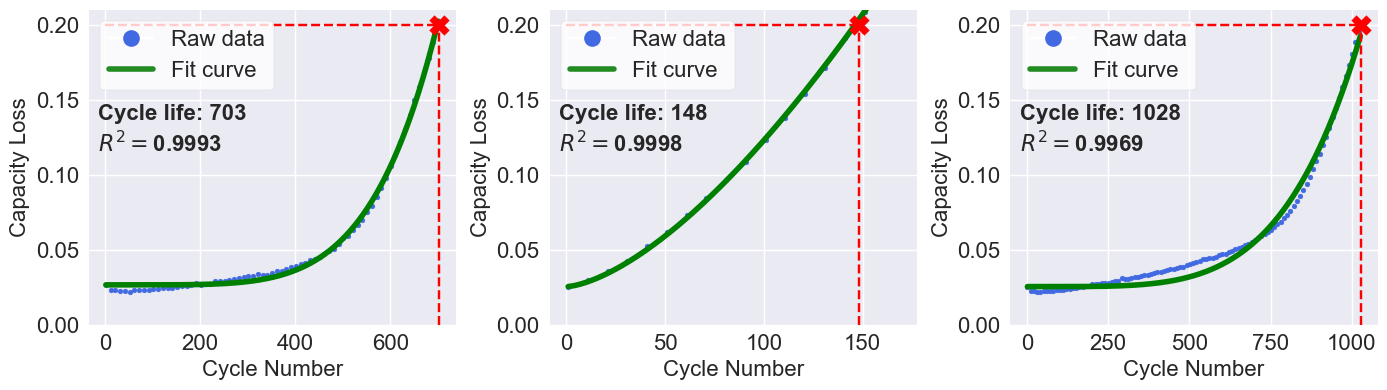

In [295]:
# partal visualization curve fits
fig,axs=plt.subplots(ncols=3,figsize=(14,4))
ids = ["b1c35","b2c1","b3c26"]
letters = ["a","b","c"]
for ix,id in enumerate(ids):
    ax = axs[ix]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = (1-bat_dict[id]['summary']['QD'][1:]/1.1)
    ax.scatter(x[::10], Y[::10],c="royalblue",s=12)

    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    Y_hat = func(x,alpha,beta)+Y[0]
    ax.plot(x, func(x,alpha,beta)+Y[0], linewidth=4, color="green")

    ax.set_xlabel("Cycle Number",fontsize=16)
    ax.set_ylabel("Capacity Loss",fontsize=16)
    ax.legend()

    rsq = np.corrcoef(Y,Y_hat)[0,1]**0.5
    ax.text(0.025,0.55,"$R^2=$"+str(round(rsq,4)),fontsize=16,fontweight="semibold",transform=ax.transAxes)

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor="royalblue", markersize=12, label="Raw data"),
                   Line2D([0], [0], color='forestgreen', lw=4, label="Fit curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white",fontsize=16)

    ax.text(0.025,0.65,"Cycle life: "+str(int(bat_dict[id]["cycle_life"][0,0])),fontsize=16, fontweight="semibold",transform=ax.transAxes)
    
    cycle_life = bat_dict[id]["cycle_life"]
    ax.hlines(0.2,0,cycle_life,color="red",linestyle="dashed")
    ax.vlines(cycle_life,0,0.2,color="red",linestyle="dashed")
    ax.scatter(cycle_life,0.2,marker="X",s=200,c="red",zorder=200)
    ax.set_ylim(0,0.21)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("../images/curve_fits_lsq_2.png",dpi=300)